### Instalações e importações

In [28]:
# Instala as bibliotecas necessárias
!pip install scikit-learn
!pip install xgboost
!pip install shap


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


     -------------------------------------- 226.0/226.0 kB 7.0 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
# Importa as bibliotecas necessárias
import warnings
warnings.filterwarnings("ignore")

# Manipulação dos dados
import numpy as np
import pandas as pd

# Visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos estatísticos 
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Métricas de avaliação
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import make_pipeline
from itertools import cycle
import shap
shap.initjs()

### Leitura do dataset

In [65]:
# Lê arquivo excel com a base de treino
df = pd.read_csv('desafio_manutencao_preditiva_treino.csv')
display(df.head(5))

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure


In [3]:
# Traz informações básicas do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    6667 non-null   int64  
 1   product_id             6667 non-null   object 
 2   type                   6667 non-null   object 
 3   air_temperature_k      6667 non-null   float64
 4   process_temperature_k  6667 non-null   float64
 5   rotational_speed_rpm   6667 non-null   int64  
 6   torque_nm              6667 non-null   float64
 7   tool_wear_min          6667 non-null   int64  
 8   failure_type           6667 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 468.9+ KB


In [4]:
# Verifica se existem dados nulos ou duplicados
print('Nulos')
print(df.isnull().sum())
print(32 * '-')
print('Duplicados')
print(df.duplicated().sum())

Nulos
udi                      0
product_id               0
type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
failure_type             0
dtype: int64
--------------------------------
Duplicados
0


### Análise exploratória

In [5]:
# Traz informações estatísticas básicas do dataset das variáveis numéricas: contagem dos dados, média, desvio padrão,
# distribuição em quantis, valores mínimos e máximos
# Chama a atenção que as variáveis apresentam valores de grandezas diferentes, algumas em dezenas e outras em milhares
# O desvio-padrão, que mostra a dispersão dos dados, é maior para a variável rotational_speed_rpm, que também possui os
# maiores valores absolutos
df.describe().T

,count,mean,std,min,25%,50%,75%,max
udi,6667.0,4994.589921,2896.125718,1.0,2496.5,4983.0,7510.5,10000.0
air_temperature_k,6667.0,299.992515,1.994710,295.3,298.3,300.0,301.5,304.5
process_temperature_k,6667.0,309.992620,1.488101,305.7,308.8,310.0,311.1,313.8
rotational_speed_rpm,6667.0,1537.419529,177.182908,1168.0,1422.5,1503.0,1612.0,2886.0
torque_nm,6667.0,40.058512,9.950804,3.8,33.2,40.2,46.8,76.6
tool_wear_min,6667.0,108.098095,63.359915,0.0,54.0,108.0,162.0,251.0


In [6]:
# Traz informações estatísticas básicas do dataset das variáveis categóricas: contagem, valores únicos, valores mais citados
# e frequência desses valores mais citados
# Chama a atenção a frequência da classe No Failure, que constitui maior parte dessa variável, bem como o tipo L, também
# maioria
df.describe(exclude=np.number).T

,count,unique,top,freq
product_id,6667,6667,M14860,1
type,6667,3,L,4022
failure_type,6667,6,No Failure,6435


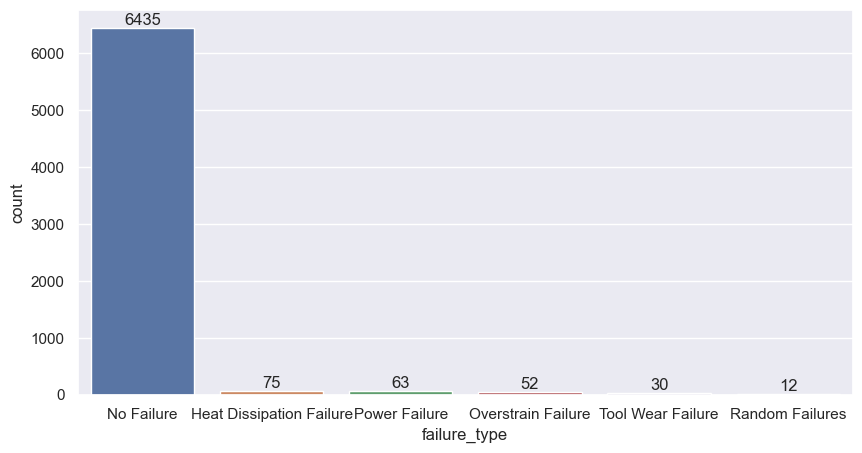

In [7]:
# Plota a frequência dos tipos de falhas em um gráfico (histograma)
# Esse gráfico mostra a quantidade de observações da variável plotada, no caso, o tipo de falha, mostrando qual a mais
# frequente e as demais em ordem decrescente
# As observações em que não há falha constituem 96% das observações totais, o que indica um forte desbalanceamento do 
# dataset 
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.countplot(data=df, x='failure_type', order=df['failure_type'].value_counts(ascending=False).index)
ax.bar_label(ax.containers[0])
plt.show()

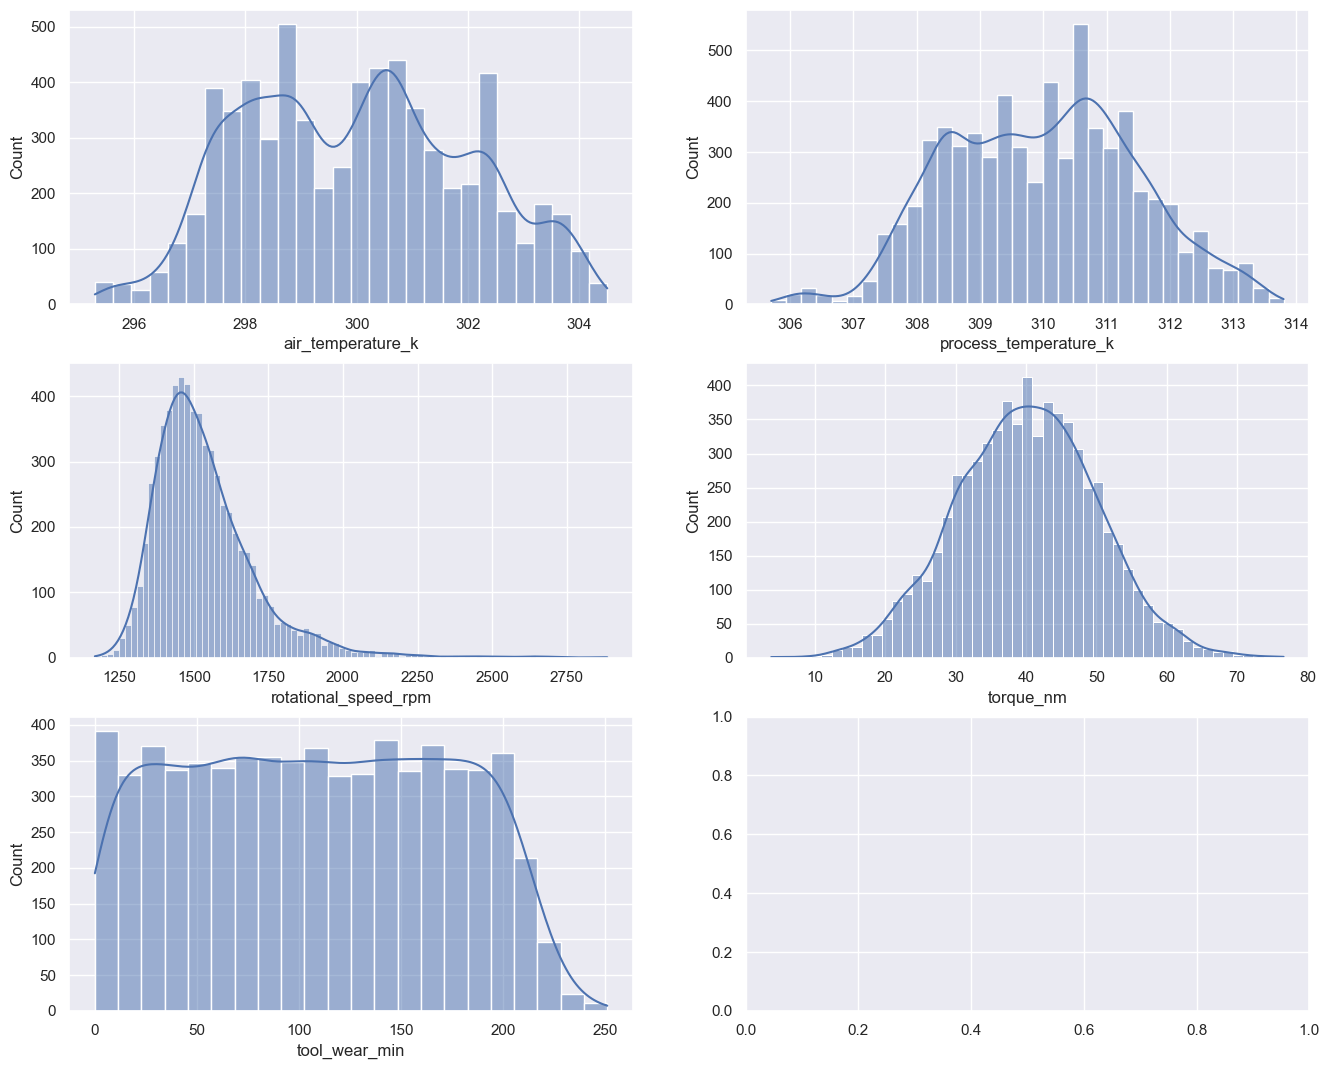

In [8]:
# Plota o histograma das variáveis para analisar a distribuição delas
# Como falado, o histograma mostra a contagem dos valores das variáveis. Do ponto de vista estatístico, traz a distribuição
# das variáveis, ou seja, como elas se comportam, se possuem valores parecidos ou mais espaçados
# As variáveis 'rotational_speed_rpm' e 'torque_nm' possuem distribuição normal
fig, axs = plt.subplots(figsize=(16,13), ncols=2, nrows=3)

sns.histplot(x=df.air_temperature_k, kde=True, ax=axs[0][0])
sns.histplot(x=df.process_temperature_k, kde=True, ax=axs[0][1])
sns.histplot(x=df.rotational_speed_rpm, kde=True, ax=axs[1][0])
sns.histplot(x=df.torque_nm, kde=True, ax=axs[1][1])
sns.histplot(x=df.tool_wear_min, kde=True, ax=axs[2][0])

plt.show()

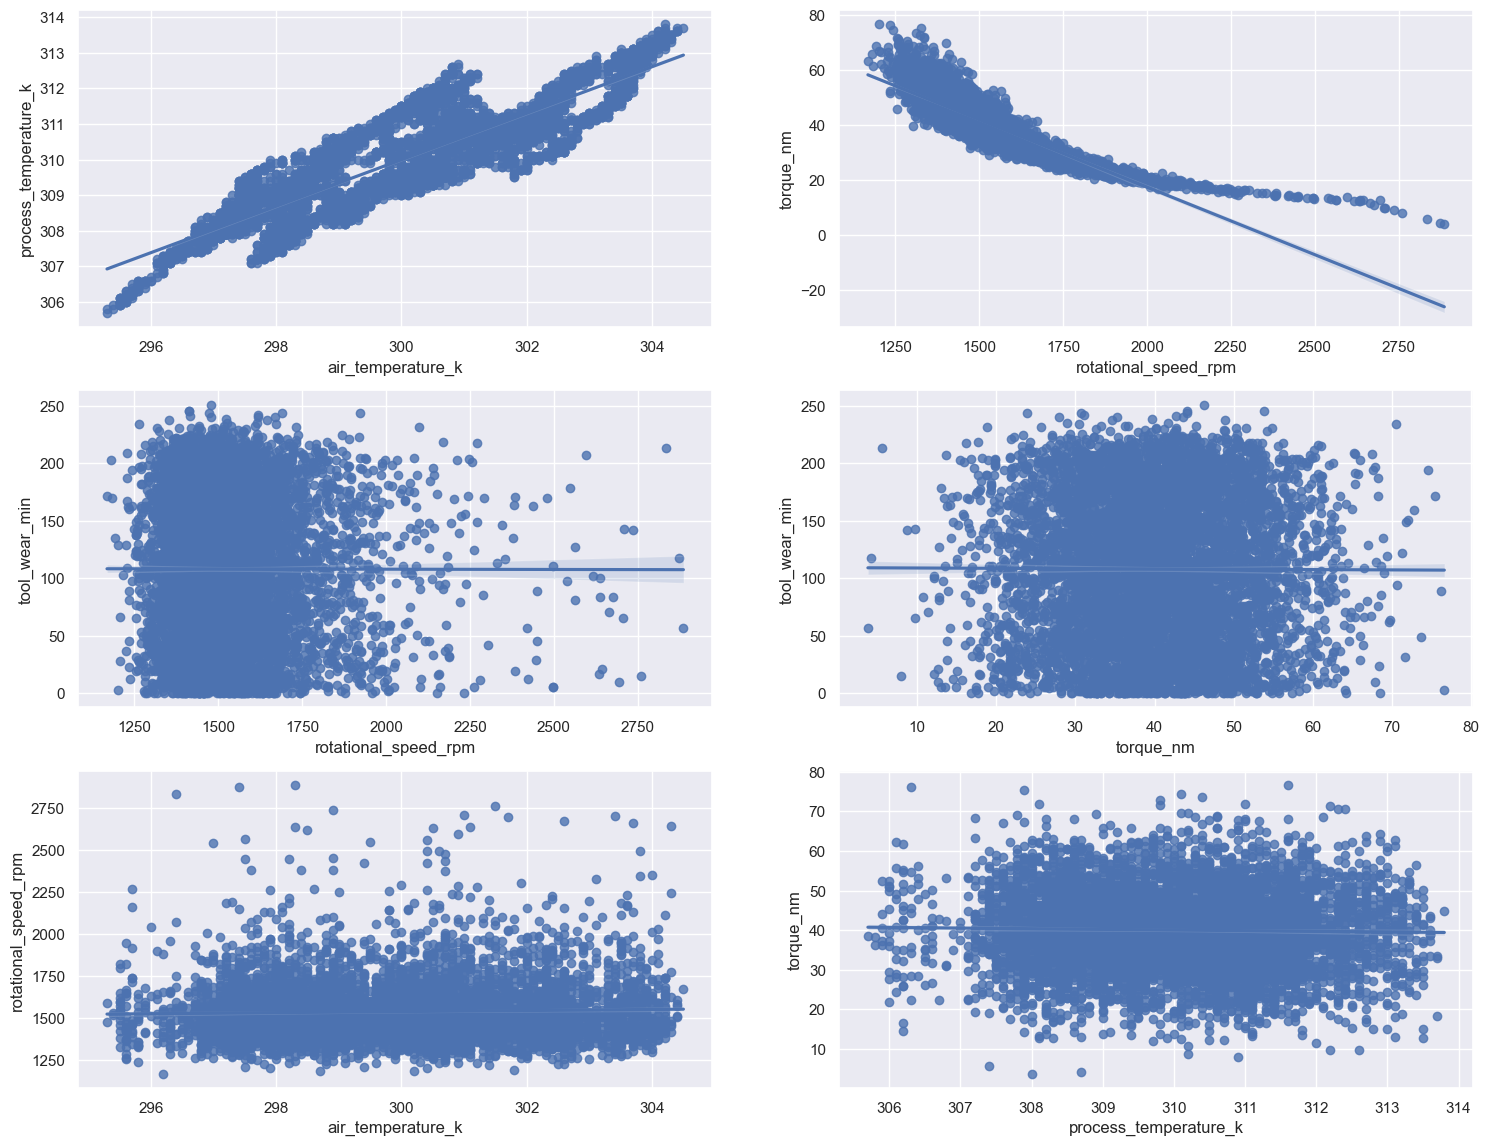

In [9]:
# Plota gráficos de dispersão entre variáveis do dataset, para verificar se existe correlação entre elas
# O gráfico de dispersão avalia a relação entre duas variáveis e se existe algum padrão nessa relação
# Verificamos que existe:
# a) Uma correlação positiva entre air_temperature_k e process_temperature_k, ou seja, quanto maior uma, maior a outra
# b) Uma correlação negativa entre rotational_speed_rpm e torque_nm, ou seja, quanto menor uma, menor a outra

fig, axs = plt.subplots(figsize=(18,14), ncols=2, nrows=3)

sns.regplot(x='air_temperature_k', y='process_temperature_k', data=df, ax=axs[0][0])
sns.regplot(x='rotational_speed_rpm', y='torque_nm', data=df, ax=axs[0][1])
sns.regplot(x='rotational_speed_rpm', y='tool_wear_min', data=df, ax=axs[1][0])
sns.regplot(x='torque_nm', y='tool_wear_min', data=df, ax=axs[1][1])
sns.regplot(x='air_temperature_k', y='rotational_speed_rpm', data=df, ax=axs[2][0])
sns.regplot(x='process_temperature_k', y='torque_nm', data=df, ax=axs[2][1])

plt.show()

<AxesSubplot: >

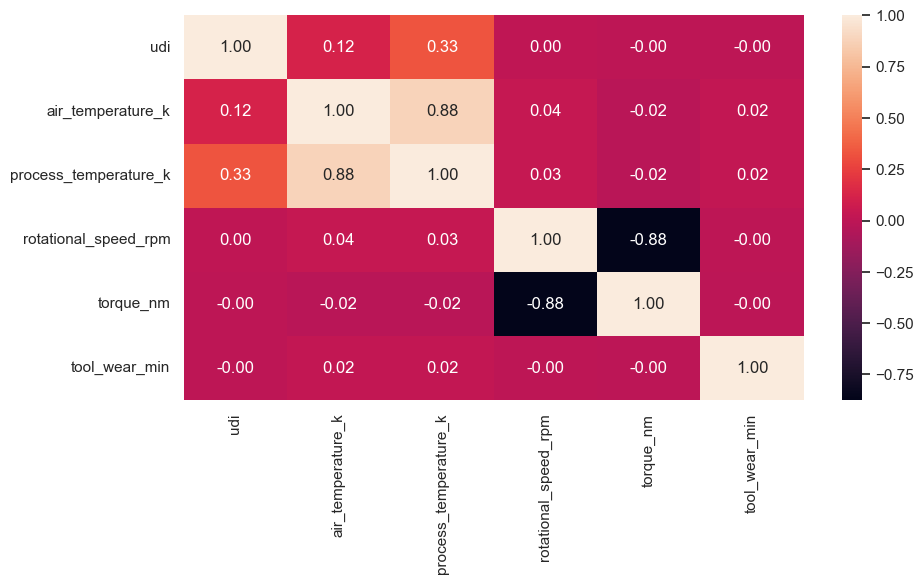

In [10]:
# Plota um gráfico de calor para mostrar as correlações entre todas as variáveis
# Quanto mais intensa é a cor e mais próximo de 1 ou -1, maior é a correlação entre as variáveis
# Foram comprovadas as correlações entendidas dos gráficos acima
# As demais variáveis nãoa presentam correlação tão forte, ou seja, mais próximas de 1 ou -1
sns.heatmap(df.corr(), annot = True, fmt = ".2f")

Após a análise exploratória dos dados, com o histograma da variável failure_type, verifica-se que ela possui muito mais observações do tipo “No failure”, ou seja, em que não existe falhas. Isso pode causar enviesamento no treinamento do modelo, uma vez que este não terá tantas oportunidades para aprender sobre as demais falhas.

Com o histograma, observa-se que as variáveis rotational_speed_rpm e torque_nm possuem distribuição normal, o que na estatística é considerada a distribuição vista na natureza de forma geral. As demais, por não serem normais, precisariam de maiores tratamentos.

Por sua vez, os gráficos de dispersão e de calor mostraram as relações existentes entre as variáveis, com destaque para uma correlação positiva entre as variáveis air_temperature_k e process_temperature_k (quanto maior uma, maior a outra) e negativa entre rotational_speed_rpm e torque_nm (quanto menor uma, menor a outra)

### Tratamento dos dados

In [66]:
# Cria um dicionário para transformar a variável 'failure_type' em numérica, para ser incluída no modelo
dicionario_failure_type = {'No Failure': 0,
            'Heat Dissipation Failure': 1,
            'Power Failure': 2,
            'Overstrain Failure': 3,
            'Tool Wear Failure': 4,
            'Random Failures': 5}
df['failure_type'] = df.failure_type.map(dicionario_failure_type)
df.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0
2,5,L47184,L,298.2,308.7,1408,40.0,9,0
3,6,M14865,M,298.1,308.6,1425,41.9,11,0
4,7,L47186,L,298.1,308.6,1558,42.4,14,0


In [67]:
# Cria um dicionário para transformar a variável 'type' em numérica, para ser incluída no modelo
dicionario_type = {'L': 0,
              'M': 1,
              'H': 2}
df['type'] = df.type.map(dicionario_type)
df.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,1,298.1,308.6,1551,42.8,0,0
1,2,L47181,0,298.2,308.7,1408,46.3,3,0
2,5,L47184,0,298.2,308.7,1408,40.0,9,0
3,6,M14865,1,298.1,308.6,1425,41.9,11,0
4,7,L47186,0,298.1,308.6,1558,42.4,14,0


In [68]:
# Seleciona as colunas das variáveis a serem usadas no modelo, excluindo 'udi', 'product_id', 'failure_type'
df = df[['type', 'air_temperature_k','process_temperature_k', 'rotational_speed_rpm', 'torque_nm','tool_wear_min', 
        'failure_type']]
display(df.head(5))

,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,298.1,308.6,1551,42.8,0,0
1,0,298.2,308.7,1408,46.3,3,0
2,0,298.2,308.7,1408,40.0,9,0
3,1,298.1,308.6,1425,41.9,11,0
4,0,298.1,308.6,1558,42.4,14,0


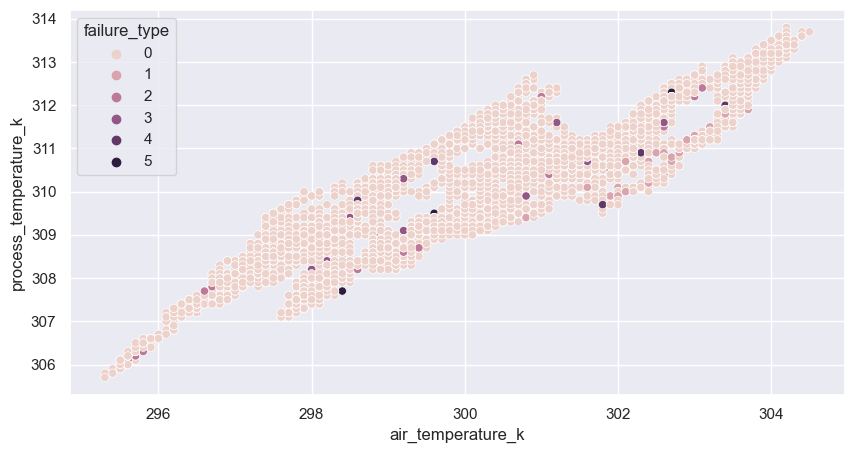

In [14]:
# Plota novamente os gráficos de dispersão das variáveis mais correlacionadas, por tipo de falha
# Não identificam-se padrões por categoria
sns.scatterplot(x='air_temperature_k', y='process_temperature_k', data=df, hue='failure_type')
plt.show()

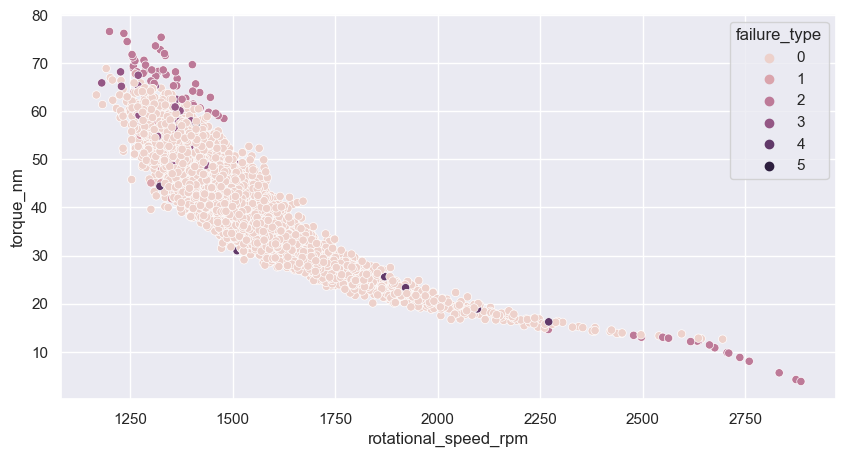

In [15]:
# Plota novamente os gráficos de dispersão das variáveis mais correlacionadas, por tipo de falha
# Não identificam-se padrões por categoria
sns.scatterplot(x='rotational_speed_rpm', y='torque_nm', data=df, hue='failure_type')
plt.show()

O tratamento das variáveis se concentrou na transformação das features categóricas em numéricas, ou seja, foram transformadas type e failure_type em números para identificar cara categoria delas por um número, e não por letras ou palavras.

### Modelagem

In [69]:
# Identificação das variáveis explicativas e target
# Divisão do dataset em treino (70%) e teste (30%)
X = df.drop(columns='failure_type' , axis=1)
y = df['failure_type']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=42)

In [70]:
# Verifica o formato de cada variável
print(f'x treino: {X_train.shape[0]} linhas, {X_train.shape[1]} colunas')
print(f'x teste: {X_test.shape[0]} linhas, {X_test.shape[1]} colunas')
print(f'y treino: {y_train.shape[0]} linhas')
print(f'y teste: {y_test.shape[0]} linhas')

x treino: 4666 linhas, 6 colunas
x teste: 2001 linhas, 6 colunas
y treino: 4666 linhas
y teste: 2001 linhas


### Regressão logística

Modelo

In [71]:
# Cria e treina o modelo e faz previsões
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

In [72]:
# Calcula as métricas de avaliação do modelo para serem mostradas na próxima seção
# Relatório com as principais medidas estatísticas (acurácia, precisão, recall e f-1 score)
relatorio_logreg = classification_report(y_test,y_pred_logreg)

# Matriz de confusão
matriz_logreg = confusion_matrix(y_test, y_pred_logreg, labels=logreg.classes_);
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=matriz_logreg, display_labels=logreg.classes_);

Métricas de avaliação

Relatório regressão logística: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1934
           1       0.00      0.00      0.00        21
           2       0.83      0.26      0.40        19
           3       0.60      0.38      0.46        16
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         4

    accuracy                           0.97      2001
   macro avg       0.40      0.27      0.31      2001
weighted avg       0.95      0.97      0.96      2001



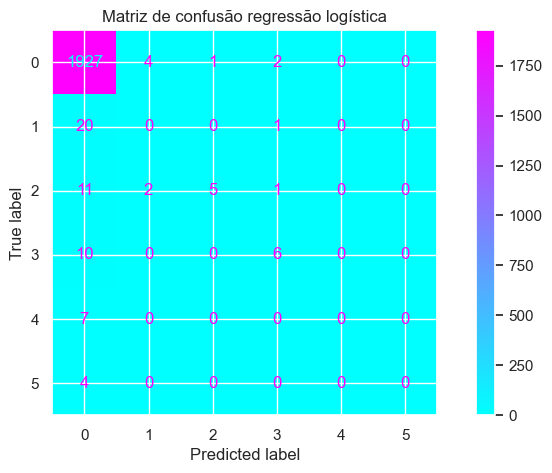

In [73]:
# Métricas da regressão logística
print("Relatório regressão logística: \n",relatorio_logreg)

disp_logreg.plot(cmap='cool');
plt.title('Matriz de confusão regressão logística');
plt.show()

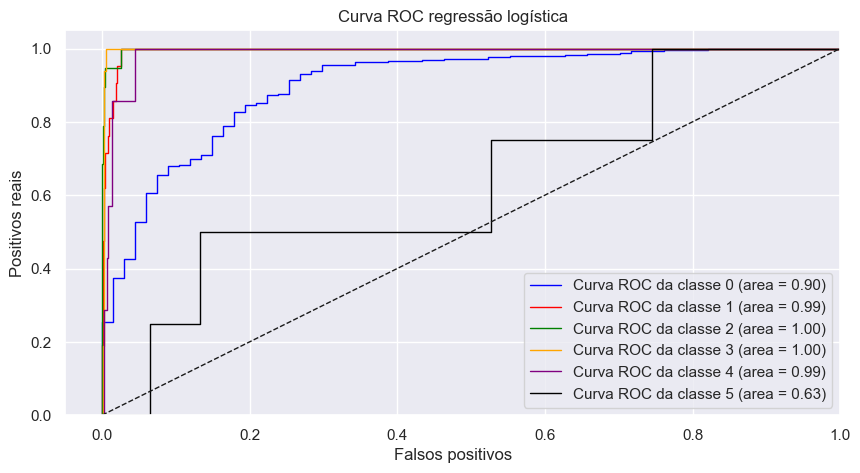

In [74]:
# AUC
# Binariza as classes da variável target
y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5])
n_classes = y.shape[1]

# Divide o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=42)

# Cria o modelo
classifier = OneVsRestClassifier(LogisticRegression(random_state=42))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Cria a curva ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'black'])
lw=1
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Curva ROC da classe {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

# Plota a curva ROC
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsos positivos')
plt.ylabel('Positivos reais')
plt.title('Curva ROC regressão logística')
plt.legend(loc="lower right")
plt.show()

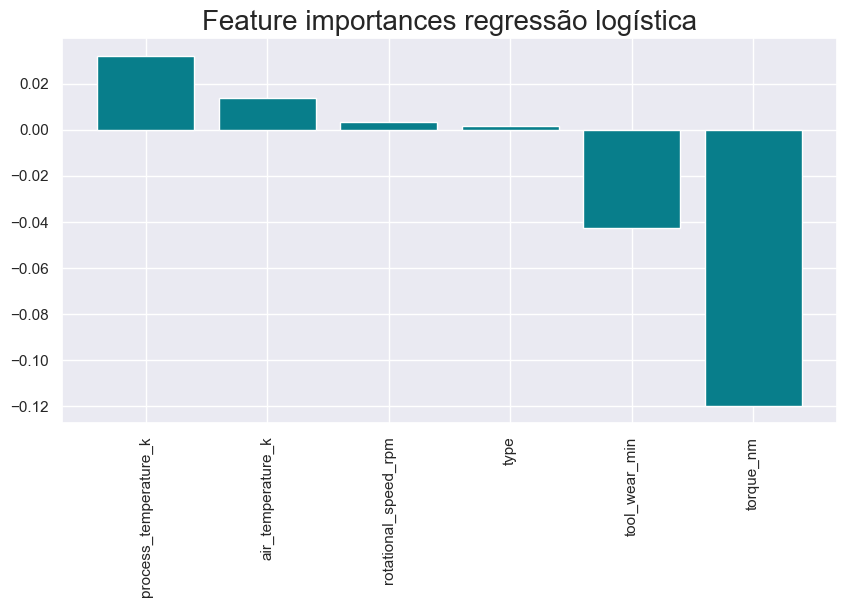

In [22]:
# Calcula o coeficiente de importância das variáveis no modelo de regressão logística
importances_logreg = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': logreg.coef_[0]
})
importances_logreg = importances_logreg.sort_values(by='Importance', ascending=False)

# Plota o gráfico de feature importance
# Observa-se que a variável que influencia mais acentuadamente é o torque_nm, de forma negativa
plt.bar(x=importances_logreg['Attribute'], height=importances_logreg['Importance'], color='#087E8B')
plt.title('Feature importances regressão logística', size=20)
plt.xticks(rotation='vertical')
plt.show()

### Random forest

Modelo

In [75]:
# Identificação das variáveis explicativas e target
# Divisão do dataset em treino (70%) e teste (30%)
# É necessário passar novamente por esse processo porque o x e o y foram redefinidos para a modelagem da curva ROC
X = df.drop(columns='failure_type' , axis=1)
y = df['failure_type']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=42)

# Cria e treina o modelo e faz previsões
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
random_forest.score(X_train, y_train)

1.0

In [76]:
# Calcula as métricas de avaliação do modelo para serem mostradas na próxima seção
# Relatório com as principais medidas estatísticas (acurácia, precisão, recall e f-1 score)
relatorio_rf = classification_report(y_test,y_pred_rf)

# Matriz de confusão
matriz_rf = confusion_matrix(y_test, y_pred_rf, labels=random_forest.classes_);
disp_rf = ConfusionMatrixDisplay(confusion_matrix=matriz_rf, display_labels=random_forest.classes_);

Métricas de avaliação

Relatório random forest: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1934
           1       0.93      0.62      0.74        21
           2       0.80      0.63      0.71        19
           3       0.91      0.62      0.74        16
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         4

    accuracy                           0.98      2001
   macro avg       0.60      0.48      0.53      2001
weighted avg       0.98      0.98      0.98      2001



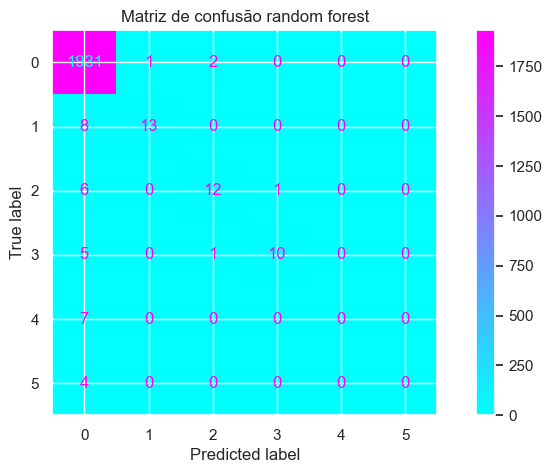

In [25]:
# Métricas da regressão logística
print("Relatório random forest: \n",relatorio_rf)

disp_rf.plot(cmap='cool');
plt.title('Matriz de confusão random forest');
plt.show()

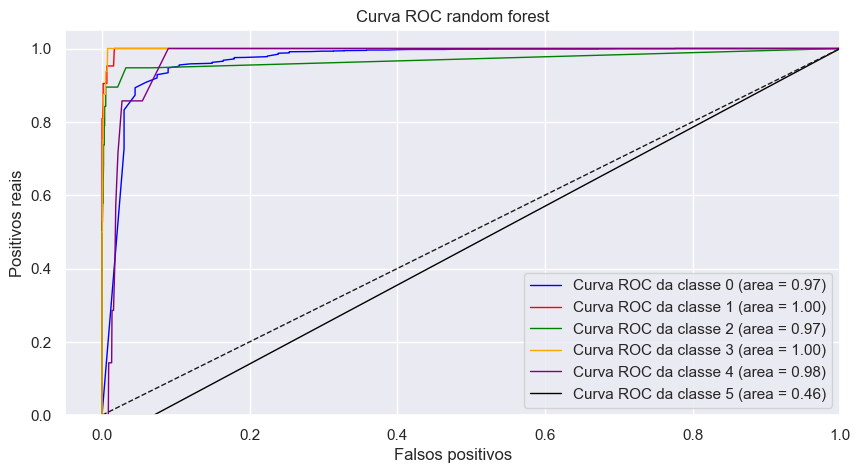

In [26]:
# AUC
# Binariza as classes da variável target
y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5])
n_classes = y.shape[1]

# Divide o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=42)

# Cria o modelo
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Cria a curva ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'black'])
lw=1
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Curva ROC da classe {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

# Plota a curva ROC
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsos positivos')
plt.ylabel('Positivos reais')
plt.title('Curva ROC random forest')
plt.legend(loc="lower right")
plt.show()

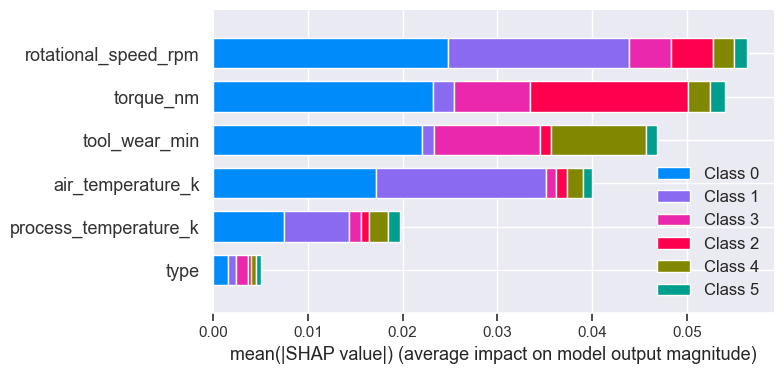

In [27]:
# Calcula os coeficiente de importância das variáveis no modelo de random forest
explainer_rf = shap.TreeExplainer(random_forest)
shap_values = explainer_rf.shap_values(X_test)

# Plota o gráfico do shapley values
# Observa-se que as variáveis que influenciam mais acentuadamente por classe são:
# a) rotational_speed_rpm: classes 0 e 5
# b) torque_nm: classe 2
# c) tool_wear_min: classes 3 e 4
# b) air_temperature_k: classe 1
shap.summary_plot(shap_values, X_train)

A previsão do tipo de falha das máquinas é feita por modelos de aprendizagem supervisionada de classificação multiclasse. Isso porque precisamos identificar, a partir das variáveis dadas no conjunto de dados, se a situação provavelmente acarretará um erro na máquina ou não. Além disso, é do tipo multiclasse, pois existem 5 tipos de falhas possíveis para serem identificadas.

Considerando a existência de somente 6 variáveis para explicar uma delas (failure_type), foram usadas por completo para o treinamento do modelo. Considerando a correlação entre elas, poderia ser feita feature engineering para a criação e transformação em somente uma, a fim de não enviesar o modelo com esse forte vínculo, pois acabam possuindo um maior peso.

Para os modelos treinados, quais sejam, regressão logística e random forest, o último apresentou uma melhor performance. Em níveis teóricos, isso pode ser explicado porque o random forest é um método de ensemble, ou seja, reúne diversos algoritmos e previsões, performando melhor que um método único como a regressão logística. Especificamente em relação ao random forest, as árvores que obtiveram um resultado fraco são compensadas por outras com resultados mais precisos, levando a uma média geral de sucesso. Por outro lado, é um modelo mais pesado, exigindo maior processamento computacional, e não é tão facilmente explicado como a regressão logística, apesar de não ser um algoritmo chamado de black box.

Sobre as métricas, foram utilizadas as métricas usuais, como acurácia, precisão, recall e f-1 score, sem preferência por nenhuma delas, bem como a matriz de confusão e a curva ROC, essas mais relevantes. A matriz de confusão mostra como o modelo previu cada classe e compara com a resposta, ou seja, podemos confrontar se o modelo conseguiu ser preciso ou não, se errou muito ou pouco. Já a área sobre a curva ROC indica e quanto mais próxima de 1, melhor é a performance do modelo, pois os valores no eixo x (falsos positivos) seriam menores e os valores do eixo y (positivos reais) seriam maiores.

Conclusões:
Sobre os modelos:

De acordo com as métricas calculadas, o modelo random forest possui uma ligeira vantagem em relação à regressão logística porque:

a)	A acurácia do random forest é levemente superior, mas as médias ponderadas de precisão, recall e f-1score são todas superiores;

b)	Pela matriz de confusão, o random forest é capaz de prever as classes 1 a 5 com maior precisão, enquanto a regressão logística não consegue identificar as classes 1, 4 e 5;

c)	Pela curva ROC, o random forest está em desvantagem na previsão da classe 5, mas supera a regressão logística nas demais, de forma geral;

d)	Por ser um método de ensemble, reúne diversos algoritmos e previsões, performando melhor que um método único como a regressão logística. Talvez não performe melhor que um ensemble de boosting, o que pode ser implementado posteriormente.


Sobre melhorias dos modelos: 

Para melhorar o desempenho dos modelos, é possível usar ferramentas como:  

a)	Feature engineering, que é a criação de variáveis a partir das originais com a finalidade de alimentar o modelo com outros elementos que podem influenciar na variável target;

b)	Normalização dos dados, uma vez que algumas variáveis não possuem distribuição normal e têm valores em escala muito superior a outras. Ex: a variável rotational_speed_rpm varia de 1.168 a 2.886, enquanto a torque_nm varia de 3,8 a 76,6;

c)	Balanceamento do dataset, porque a classe 0, de que não existe falha, compõe 96% do dataset, assim, restam poucas observações para que o modelo aprenda a identificar as demais falhas.

### Exportação para arquivo csv

In [123]:
# Lê o dataset de teste, para o que devem ser feitas as predições
df2=pd.read_csv('desafio_manutencao_preditiva_teste.csv')

# Aplica as transformações feitas no dataset de treino para a variável type e seleciona as colunas
df2['type'] = df2.type.map(dicionario_type)
X2 = df2[['type', 'air_temperature_k','process_temperature_k', 'rotational_speed_rpm', 'torque_nm','tool_wear_min']]

# Cria uma coluna e aplica a previsão do modelo treinado
df2['failure_type'] = random_forest.predict(X2)

# Verifica a contagem dos valores preditos
display(df2['failure_type'].value_counts())

# Cria um dataset com as duas colunas requeridas no desafio (rowNumber, predictedValues)
# Reseta o índice para usar como o número da linha, seleciona as colunas, renomeia e mostra as primeiras linhas
df_final = df2.reset_index()
df_final = df_final[['index', 'failure_type']]
df_final = df_final.rename(columns={'index': 'rowNumber', 'failure_type': 'predictedValues'})
display(df_final.head())

# Exporta para o arquivo predicted.csv
arquivo_final = df_final.to_csv('predicted.csv', columns=['rowNumber','predictedValues'],index=False)

0    3266
2      28
1      23
3      15
4       1
Name: failure_type, dtype: int64

,rowNumber,predictedValues
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
